# Visium HD Multi-sample Analysis in Python: a Tutorial in Google Colab

*Note: 10x Genomics does not provide support for community-developed tools and makes no guarantees regarding their function or performance. Please contact tool developers with any questions.*

##How to Use This Google Colab
1. **Ensure Python 3 is the programming language and High RAM is enabled**. Navigate to `Runtime` > `Change runtime type` and check that *Runtime type* is set to `Python 3` and *Hardware accelerator* is set to `CPU` and `High RAM`. `High RAM` is required to process the data using Google Colab.

2. Click the **Connect** button in the top-right corner.

3. You can run the analysis using the provided datasets or load your own data by following the instructions at the beginning of each section.

If you wish to download and run the code locally instead of on the cloud, go to `File` > `Download` and select `Download .ipynb` for a notebook or `Download .py` for a Python script.

_Note: This Colab was developed with Google Colab Pro due to the size of the datasets. To run the code successfully, the High RAM option must be enabled. If you do not wish to upgrade to Google Colab Pro, it is recommended to download the code and run it locally._

# **Section 1: Python Environment Setup and Library Installation**

## **Python Libraries Used in this Analysis Guide**
This Analysis Guide will require the use of a few Python libraries. Some of the libraries are standard Python libraries like `gc` and `json`, but many of these libraries require installation.

* **[spatialdata](https://spatialdata.scverse.org/en/latest/index.html)** (as spd): A library for storing and manipulating multiomic spatial data. It can handle images, points, shapes (like polygons or circles), and tables (like `AnnData` objects). In the analysis, we import the `Identity` and `Scale` functions from `Spatialdata`'s `transformations` module.
* **[spatialdata_plot](https://github.com/scverse/spatialdata-plot)**: The plotting extension for `spatialdata`, enabling integrated visualization of images, shapes, and associated omics data.
* **[spatialdata_io](https://spatialdata.scverse.org/projects/io/en/latest/)** (as so): A sub-package of `spatialdata` designed for reading and writing various spatial omics file formats.
* **[geosketch](https://github.com/brianhie/geosketch)** (as sketch): A package used to downsample large datasets while preserving their underlying geometric structure and biological variability. This is a Python implementation of the algorithm described by *Hie et al. 2019*.
* **[numpy](https://numpy.org/)** (as np): This package provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
* **[pandas](https://pandas.pydata.org/)** (as pd): A library for data manipulation and analysis, providing data structures like DataFrames.
* **[scanpy](https://scanpy.readthedocs.io/en/stable/index.html)** (as sc): A toolkit for analyzing gene expression data installed with `Squidpy`, used for tasks such as preprocessing, dimensionality reduction (PCA, UMAP), clustering, and differential gene expression analysis.
* **scanpy.external** (as sce): A module within `Scanpy` that provides access to Harmonypy for batch correction. Harmonypy is a Python port of the R Harmony library used for dataset integration.
* **[json](https://docs.python.org/3/library/json.html)**: A standard Python library for importing and exporting JSON files. It is used in the creation of the `Spatialdata` object.
* **[gc](https://docs.python.org/3/library/gc.html)**: A standard Python library that provides an interface to the garbage collector that can help with memory management.
* **[geopandas](https://geopandas.org/en/stable/)** (as gpd): A library for working with geospatial vector data (like points, lines, and polygons).
* **spatialdata.models**: The functions imported from `spatialdata.models` library are used for defining and validating the structure and types of spatial data within the `Spatialdata` object.
* **[matplotlib.pyplot](https://matplotlib.org/stable/tutorials/pyplot.html)** (as plt): A Python package for data visualization.
* **[pydeseq2](https://pydeseq2.readthedocs.io/en/stable/)**: A Python implementation of the DESeq2 R library, used for differential gene expression analysis of count data. We import the `dds` and `ds` modules from the `pydeseq2` package.
* **[PIL](https://github.com/python-pillow/Pillow)**: A Python image processing package for opening, manipulating, and saving many images.
* **[shapely](https://pypi.org/project/shapely/)**: A Python package for manipulating and analyzing geometric objects. We import the `Polygon` module from the `shapely.geometry` module.

---

## **Installing Required Python Libraries to the Python Environment**
If you are not running the code using Google Colab, we recommend creating a fresh Python environment. In this guide, we use the Python package manager `uv` to install the required libraries.

To set up a local Python environment, follow these steps:

**Create a virtual environment (recommended):**

```python -m venv myenv```

**Activate the environment:**

```source myenv/bin/activate```


**Install required packages:**

```
(myenv) $ pip install --upgrade pip
(myenv) $ pip install  anndata==0.12.0 pydeseq2==0.5.2 squidpy==1.6.5 spatialdata==0.4.0 "spatialdata[extra]" geosketch==1.3 harmonypy==0.0.10 igraph==0.11.8
```

The Python script in this guide was written with Python v3.10 and the `spatialdata[extra]` package, which includes `spatialdata-io` v0.2.0 and `spatialdata-plot` v0.2.10.

If you are using Google Colab, execute each code cell to run the analysis.

## **Library Import**
Now that we have installed all required libraries, we import the necessary libraries.

*Note: If the error message `FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/xarray-2025.3.1.dist-info/METADATA'`, is displayed after running the next code cell, execute the code cell again.*

In [4]:
import spatialdata as spd
import spatialdata_plot as splt
import spatialdata_io as so
import geosketch as sketch
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce

import json
import gc
import geopandas as gpd
from spatialdata.models import Image2DModel, TableModel, ShapesModel
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from PIL import Image
from spatialdata.transformations import Identity, Scale
from shapely.geometry import Polygon


## **Helper Functions**
We use two custom helper function in this guide, which are defined in the next set of code cells.

The function `create_zarr` takes the raw output files from 10x Genomics' Visium HD processing and structures them into a single Zarr file, making the data ready for spatial analysis using libraries like `spatialdata`. It takes input paths, loads and prepares data, defines coordinate systems and transformations, processes the cell segmentation, integrates it with the `AnnData` object, creates `SpatialData` elements, and writes all of this to a Zarr file.

It takes five inputs:
* **`image_path`**: The path to the image file.
* **`count_matrix_path`**: The path to the cell segmentation filtered feature-barcode count matrix file.
* **`scale_factors_path`**: The path to the scale factors JSON file.
* **`geojson_path`**: The path to the cell segmentation GeoJSON file.
* **`sample_name`**: A name for the Zarr output file.

In this guide, we use the `hires_image.png` file to reduce the size of the Zarr file and the RAM requirement, which speeds up the code. The full-resolution microscope image can also be used, with adjustments to the code to properly scale the cell segmentation GeoJSON file. The images required in the final Zarr file will depend on the downstream analyses.

In [12]:
def create_zarr(count_matrix_path,
                image_path,
                scale_factors_path,
                geojson_path,
                sample_name
):
    print(sample_name)

    # Load and Prepare Raw Data
    # Define file paths
    COUNT_MATRIX_PATH = count_matrix_path
    IMAGE_PATH = image_path
    SCALE_FACTORS_PATH = scale_factors_path
    GEOJSON_PATH = geojson_path

    # Load AnnData
    adata = sc.read_10x_h5(COUNT_MATRIX_PATH)
    adata.var_names_make_unique()
    adata.obs['sample'] = sample_name
    adata.obs.index = sample_name +"_" + adata.obs.index.astype(str)

    # Load and preprocess image data
    image_data = np.array(Image.open(IMAGE_PATH))
    if image_data.ndim == 2:
        image_data = image_data[np.newaxis, :, :] # Add channel dimension for grayscale
    elif image_data.ndim == 3:
        image_data = np.transpose(image_data, (2, 0, 1)) # (H, W, C) -> (C, H, W) for spatialdata

    # Load scale factors
    with open(SCALE_FACTORS_PATH, 'r') as f:
        scale_data = json.load(f)

    # Load GeoJSON data
    with open(GEOJSON_PATH, 'r') as f:
        geojson_data = json.load(f)

    # Define coordinate systems:
    # `downscale_to_hires`: The coordinate system where shapes are located, scaled relative to the hires resolution.

    hires_scale = scale_data['tissue_hires_scalef']

    # Transformation for shapes (from pixel to downscale_to_hires)
    shapes_transformations = {
       "downscale_to_hires": Scale(np.array([hires_scale, hires_scale]), axes=("x", "y")) # if the high-resolution microscope image is being used and Identity() transform would be performed.
    }

    # Transformation for the 'hires_tissue_image' (it's already in the 'downscale_to_hires' space visually)
    image_transformations = {
        "downscale_to_hires": Identity()
    }

    # Process Cell Segmentation (GeoJSON) and Integrate with AnnData

    # Create a mapping from adata.obs.index to geojson features
    geojson_features_map = {
        f"{sample_name}_cellid_{feature['properties']['cell_id']:09d}-1": feature
        for feature in geojson_data['features']
    }

    # Prepare data for GeoDataFrame and update adata.obs
    geometries = []
    cell_ids_ordered = []

    for obs_index_str in adata.obs.index:
        feature = geojson_features_map.get(obs_index_str)
        if feature:
            # Create shapely Polygon from coordinates
            polygon_coords = np.array(feature['geometry']['coordinates'][0])
            geometries.append(Polygon(polygon_coords))
            cell_ids_ordered.append(obs_index_str)
        else:
            geometries.append(None) # Or a suitable placeholder
            cell_ids_ordered.append(obs_index_str)

    # Remove None entries if any (or handle them upstream)
    valid_indices = [i for i, geom in enumerate(geometries) if geom is not None]
    geometries = [geometries[i] for i in valid_indices]
    cell_ids_ordered = [cell_ids_ordered[i] for i in valid_indices]


    # Create GeoDataFrame for shapes
    shapes_gdf = gpd.GeoDataFrame({
        'cell_id': cell_ids_ordered,
        'geometry': geometries
    }, index=cell_ids_ordered)
    # Update adata.obs with cluster information and spatial identifiers
    adata.obs['cell_id'] = adata.obs.index
    adata.obs['region'] = sample_name + '_cell_boundaries'
    adata.obs['region'] = adata.obs['region'].astype('category')
    adata = adata[shapes_gdf.index].copy() # Filter adata to match shapes_gdf

    # Define names for SpatialData elements
    IMAGE_KEY =  sample_name + '_hires_tissue_image'
    TABLE_KEY =  'segmentation_counts'
    SHAPES_KEY = sample_name + '_cell_boundaries'

    # Create SpatialData elements directly
    sdata = spd.SpatialData(
        images={
            IMAGE_KEY: Image2DModel.parse(image_data, transformations=image_transformations)
        },
        tables={
            TABLE_KEY: TableModel.parse(
                adata,
                region=SHAPES_KEY, # Link table to shapes element
                region_key='region', # Column in adata.obs indicating region name
                instance_key='cell_id' # Column in adata.obs with instance IDs (cell_id)
            )
        },
        shapes={
            SHAPES_KEY: ShapesModel.parse(shapes_gdf, transformations=shapes_transformations)
        }
    )

    sdata.write(sample_name, overwrite=True)
    del sdata
    gc.collect()




If you want to use the square-bin outputs instead of the segmentation-based bin outputs, you can use the `so.visium_hd` function from `spatialdata` version 0.4.0. This simplifies the `create_zarr` function, as seen in this code:

```
def create_zarr(
                path_to_outputs,
                zarr_name,
                bin_size
):
    print(zarr_name)
    sdata = so.visium_hd(path=path_to_outputs,
                         load_all_images=True, bin_size=bin_size)
    sdata.write(zarr_name, overwrite=True)
    del sdata
```

Starting with  `spatialdata-io` version 0.5.0, you can directly import the segmentation results using the  `so.visium_hd` function. If you prefer this approach, the code would be:

In [11]:
# def create_zarr(
#                 path_to_outputs,
#                 zarr_name,
#                 bin_size
# ):
#     print(zarr_name)
#     sdata = so.visium_hd(path=path_to_outputs,
#                          load_all_images=True,
#    load_segmentations_only=True,
#    			        load_nucleus_segmentations=True,
# )
#     sdata.write(zarr_name, overwrite=True)
#     del sdata

Please note that using the `so.visium_hd` function will result in different names in the `SpatialData` object for the image, shapes, tables, and coordinate systems, requiring corresponding adjustments to the code.

The second helper function `crop0` ensures that the images generated from the analysis are cropped to the region of interest, aligning with the Visium HD Capture Area of each sample. It takes as input a `SpatialData` object (`x`), a target coordinate system (`crs`), and a bounding box dictionary (`bbox`). A bounding box dictionary is a way to represent a rectangular region in a 2D space using a Python dictionary. It typically contains the minimum and maximum coordinates for both the x and y axes that define the boundaries of the box. The function assumes that the `bbox` dictionary was created using `spd.get_extent` with the same coordinate system. Internally, the function calls `spd.bounding_box_query` and uses the minimum and maximum coordinates from the dictionary to subset the data from the `SpatialData` object that falls within this defined rectangle. This ensures that subsequent visualizations or analyses are focused only on the relevant part of the data. This is required because the microscope image is often larger than the Visium HD Gene Expression capture area.

In [7]:
def crop0(x,crs,bbox):
    return spd.bounding_box_query(
        x,
        min_coordinate=[bbox['x'][0], bbox['y'][0]],
        max_coordinate=[bbox['x'][1], bbox['y'][1]],
        axes=("x", "y"),
        target_coordinate_system=crs,
    )

#**Section 2. Data Download Links**



The datasets used in this Analysis Guide are publicly available from 10x Genomics:

[Human Colon Cancer and Normal Adjacent Datasets](https://www.10xgenomics.com/products/visium-hd-spatial-gene-expression/dataset-human-crc)



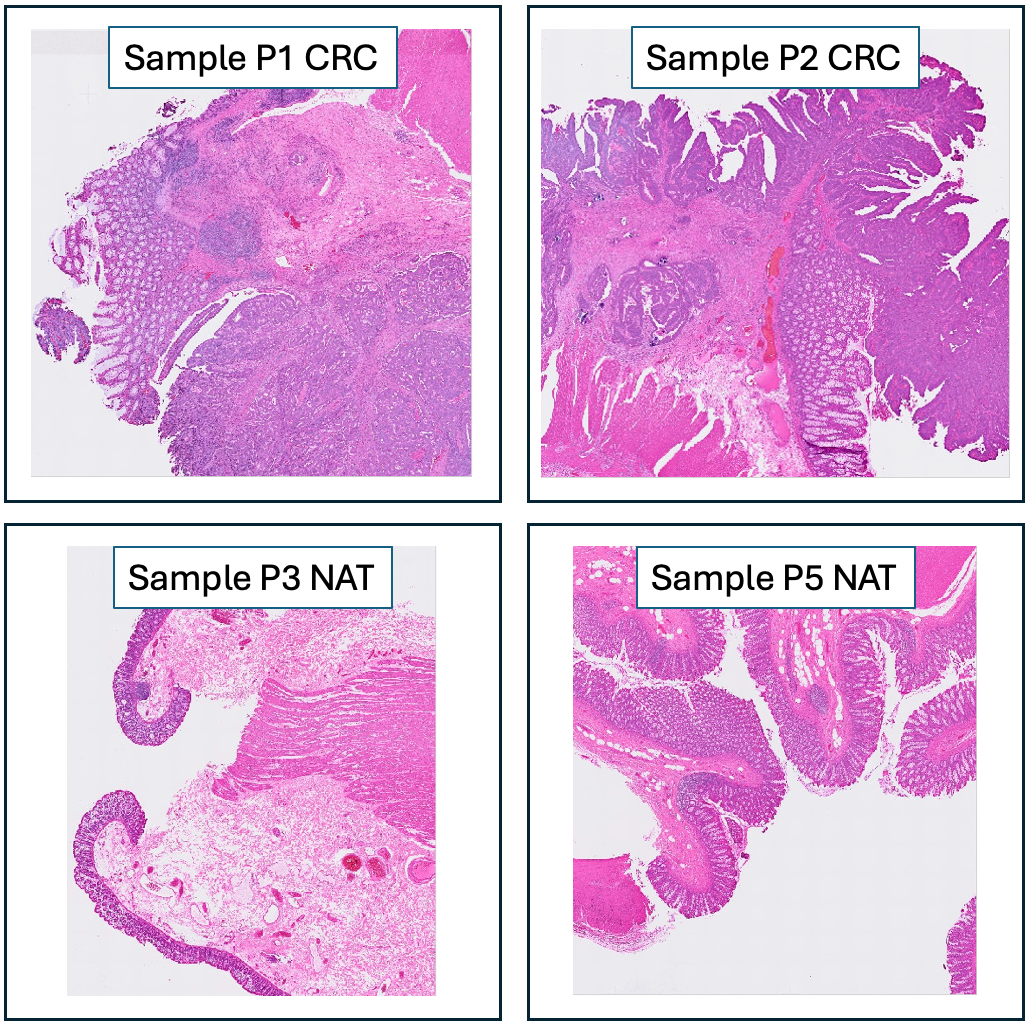


The specific datasets used in this guide are:
* **Visium HD, Sample P1 Colon Cancer (CRC)**: Human colon cancer tissue (Patient 1).
* **Visium HD, Sample P2 CRC**: Human colon cancer tissue (Patient 2).
* **Visium HD, Sample P3 Normal Adjacent Tissue (NAT)**: Normal adjacent human colon tissue (Patient 3).
* **Visium HD, Sample P5 NAT**: Normal adjacent human colon tissue (Patient 5).

If you are working with your own data, for each dataset, the `outs` directory will contain the cell segmentation based binned output and spatial output data. For a more detailed description of Visium HD's outputs, see the documentation on our support [site](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/output-overview).

The data was originally processed using `spaceranger count` v3.0.0. However, to generate the Space Ranger cell segmentation outputs used in this guide, the public colon cancer and normal adjacent tissue datasets were reprocessed using `spaceranger count` v4.0.1.

The next code cell downloads and extracts the data required to make the spatial Zarr files and `SpatialData` objects.

In [15]:
! pwd

/Users/jmakings/Documents/Projects/visiumhd/notebooks


In [17]:
%%capture
!cd ../data/raw/
# !wget https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/multisample_raw_data.tar.gz
!curl -L -O https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/multisample_raw_data.tar.gz
!tar xvzf multisample_raw_data.tar.gz
!rm multisample_raw_data.tar.gz

OSError: [Errno 5] Input/output error

# **Section 3: Conversion of Space Ranger Output to Zarr Format and SpatialData Object Creation**

We begin this section by converting the standard Visium HD output into a Zarr file, as the `spatialdata` library expects data in this format. If you are running this code locally, this code needs to be run only once, as the datasets can be loaded directly from the saved Zarr files afterward.

In the following code snippet, a dictionary is created where each sample name serves as a unique key. The value associated with each key is a list containing:
* the path and filename of the filtered feature-cell matrix in `h5` format.
* the location and name of the image to be stored in the `SpatialData` object.
* the scale factors JSON file, so that the cell segmentation results can beoverlaid onto the tissue image.
* the cell segmentation GeoJSON file, so the cell segmentation results can be visualized on the tissue image.
* the desired name for the Zarr file.

Each key-value pair in this dictionary is then processed by the `create_zarr` helper function. For this specific example, we only use the `tissue_hires_image.png`. Other images, such as a high-resolution microscope image or CytAssist image, can be added to the `SpatialData` object.


In [13]:
# Create and save Zarr files for the cell segmentation outputs.
samples = {
    "Colon_Cancer_P1":["data/Cancer_P1_filtered_feature_cell_matrix.h5",
                      "data/Cancer_P1_tissue_hires_image.png",
                      "data/Cancer_P1_scalefactors_json.json",
                      "data/Cancer_P1_cell_segmentations.geojson",
                      "Colon_Cancer_P1"],
    "Colon_Cancer_P2":["data/Cancer_P2_filtered_feature_cell_matrix.h5",
                      "data/Cancer_P2_tissue_hires_image.png",
                      "data/Cancer_P2_scalefactors_json.json",
                      "data/Cancer_P2_cell_segmentations.geojson",
                      "Colon_Cancer_P2"],
    "Colon_Normal_P3":["data/Norm_P3_filtered_feature_cell_matrix.h5",
                      "data/Norm_P3_tissue_hires_image.png",
                      "data/Norm_P3_scalefactors_json.json",
                      "data/Norm_P3_cell_segmentations.geojson",
                      "Colon_Normal_P3"],
    "Colon_Normal_P5":["data/Norm_P5_filtered_feature_cell_matrix.h5",
                      "data/Norm_P5_tissue_hires_image.png",
                      "data/Norm_P5_scalefactors_json.json",
                      "data/Norm_P5_cell_segmentations.geojson",
                      "Colon_Normal_P5"],
}
print("Saving zarr files")
for key, inputs in samples.items():
    create_zarr(count_matrix_path=inputs[0],
                image_path=inputs[1],
                scale_factors_path=inputs[2],
                geojson_path=inputs[3],
                sample_name=inputs[4])

del samples, inputs, key
gc.collect()

Saving zarr files
Colon_Cancer_P1


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'data/Cancer_P1_filtered_feature_cell_matrix.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)